# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep = ';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   AGER_TYP               891221 non-null  int64  
 1   ALTERSKATEGORIE_GROB   891221 non-null  int64  
 2   ANREDE_KZ              891221 non-null  int64  
 3   CJT_GESAMTTYP          886367 non-null  float64
 4   FINANZ_MINIMALIST      891221 non-null  int64  
 5   FINANZ_SPARER          891221 non-null  int64  
 6   FINANZ_VORSORGER       891221 non-null  int64  
 7   FINANZ_ANLEGER         891221 non-null  int64  
 8   FINANZ_UNAUFFAELLIGER  891221 non-null  int64  
 9   FINANZ_HAUSBAUER       891221 non-null  int64  
 10  FINANZTYP              891221 non-null  int64  
 11  GEBURTSJAHR            891221 non-null  int64  
 12  GFK_URLAUBERTYP        886367 non-null  float64
 13  GREEN_AVANTGARDE       891221 non-null  int64  
 14  HEALTH_TYP             891221 non-nu

In [4]:
azdias.head(n=5)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   attribute           85 non-null     object
 1   information_level   85 non-null     object
 2   type                85 non-null     object
 3   missing_or_unknown  85 non-null     object
dtypes: object(4)
memory usage: 2.8+ KB


In [7]:
feat_info.head(5)

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,AGER_TYP,person,ordinal,[-1]
freq,1,43,49,26


#### Observation:
It appears that there is quite a good amount of missing values in the data sets both naturally and missing/unknown.

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [9]:
# Identify missing or unknown data values and convert them to NaNs.
pd.set_option('display.max_rows', 500) # setting max rows dispay to 500
pd.set_option('display.max_columns', 200) # setting max rows dispay to 500
natur_missing = azdias.isnull().sum() # Naturally missing data values in each column
display(natur_missing)

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [10]:
print ("Total count of naturally missing values = ", natur_missing.sum())

Total count of naturally missing values =  4896838


In [11]:
# 'missing_or_unknown' column is loaded as string object in the data frame 'feat_info' and this needs to be
# converted to list to make use of numpy module and replace missing/unknown  values with NaN

# Function to covert the string object to list object with integers and strings 'X', 'XX'

# This function takes a string of a list as input and returns a list containing integers and strings 'X', 'XX'.
def str_obj_to_list_int(str_obj):

    list_int_str = [] # Initiating new list 
    str_obj = str_obj[1:-1].split(',') # This removes the "[" and "]"  and splits on "," creating a list of strings
    
# Loop through the list of strings and convert any numeric values to integer type, and keep strings 'X', 'XX' same as string
    for i in str_obj:
        try:
            list_int_str.append(int(i))
        except:
            list_int_str.append(i)
    return list_int_str

In [12]:
#Applying the function 'str_obj_to_list_int' to convert the string object 'missing_or_unknown' column to list of integers and strings
missing_data_list = feat_info['missing_or_unknown'].apply(str_obj_to_list_int)

In [13]:
display(missing_data_list)

0        [-1, 0]
1     [-1, 0, 9]
2        [-1, 0]
3            [0]
4           [-1]
5           [-1]
6           [-1]
7           [-1]
8           [-1]
9           [-1]
10          [-1]
11           [0]
12            []
13            []
14       [-1, 0]
15           [0]
16           [0]
17           [0]
18           [0]
19           [0]
20           [0]
21       [-1, 0]
22       [-1, 0]
23           [0]
24       [-1, 9]
25       [-1, 9]
26       [-1, 9]
27       [-1, 9]
28       [-1, 9]
29       [-1, 9]
30       [-1, 9]
31       [-1, 9]
32       [-1, 9]
33       [-1, 9]
34       [-1, 9]
35       [-1, 9]
36       [-1, 9]
37       [-1, 9]
38          [-1]
39          [-1]
40       [-1, 0]
41          [-1]
42       [-1, 9]
43           [0]
44            []
45            []
46       [-1, 0]
47          [-1]
48       [-1, 0]
49       [-1, 0]
50           [0]
51            []
52       [-1, 0]
53            []
54           [0]
55          [-1]
56          [-1]
57       [-1, X]
58          [X

In [14]:
azdias_update_1 = azdias.copy() #creating a copy of the original dataframe

# replace missing/unknown  values with NaN
for missing_list in range (len (missing_data_list)): 
    column_id = feat_info.iloc [missing_list] ['attribute'] #saving column name
    azdias_update_1[column_id].replace (to_replace = missing_data_list[missing_list], value = np.NaN, regex = True, inplace = True)

In [15]:
azdias_update_1.sample(n=10, random_state = 0)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
517045,1.0,4.0,2,1.0,2,1,5,2,1,5,6,NaN,5.0,0,2.0,6.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,5.0,2,3,2,2,2,7,7,2,2,6,6,6,2,1,3.0,0.0,NaN,1.0,3,7.0,1.0,0.0,6.0,NaN,6.0,9.0,49.0,0.0,3.0,3.0,1992.0,O,3.0,8,8C,54,0.0,0.0,0.0,1.0,NaN,1.0,7.0,5.0,1.0,4.0,4.0,1.0,0.0,5.0,542.0,1.0,4.0,3.0,2.0,4.0,4.0,2.0,4.0,7.0,3.0
411230,NaN,3.0,2,3.0,2,2,4,1,3,3,5,NaN,5.0,1,2.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,9.0,5.0,2,3,3,2,2,6,6,1,4,7,6,7,3,3,2.0,0.0,NaN,2.0,3,NaN,2.0,0.0,4.0,NaN,4.0,9.0,19.0,0.0,1.0,3.0,1992.0,W,2.0,6,6B,43,0.0,0.0,0.0,2.0,4.0,1.0,3.0,5.0,3.0,3.0,1.0,1.0,1.0,1.0,767.0,2.0,2.0,1.0,1.0,1.0,5.0,4.0,3.0,8.0,3.0
252730,NaN,4.0,1,4.0,4,1,5,1,2,4,5,NaN,11.0,0,1.0,31.0,10.0,10.0,5.0,1.0,1.0,1.0,NaN,5.0,3,2,2,6,6,7,7,6,3,3,3,2,2,1,3.0,0.0,NaN,1.0,4,18.0,2.0,0.0,5.0,4.0,1.0,8.0,3.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,1.0,2.0,0.0,0.0,NaN,3.0,6.0,6.0,1.0,3.0,3.0,2.0,5.0,7.0,267.0,1.0,4.0,3.0,2.0,5.0,3.0,2.0,3.0,7.0,5.0
233415,NaN,4.0,2,2.0,5,1,5,2,1,3,6,NaN,12.0,0,1.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,5.0,3.0,1,3,1,1,2,5,7,1,3,4,6,6,1,1,3.0,0.0,NaN,1.0,3,NaN,0.0,0.0,3.0,NaN,NaN,8.0,1.0,0.0,1.0,7.0,1995.0,O,7.0,3,3C,24,3.0,0.0,0.0,0.0,1.0,4.0,NaN,NaN,NaN,5.0,2.0,5.0,1.0,3.0,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0,3.0
409998,2.0,4.0,1,2.0,5,1,4,1,1,3,6,NaN,3.0,1,1.0,17.0,5.0,2.0,2.0,7.0,3.0,1.0,4.0,5.0,6,4,2,6,7,7,3,4,1,3,1,1,1,1,3.0,0.0,NaN,1.0,3,9.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,O,7.0,8,8C,54,1.0,0.0,0.0,0.0,NaN,5.0,7.0,1.0,8.0,5.0,2.0,5.0,2.0,2.0,339.0,3.0,1.0,0.0,1.0,1.0,3.0,3.0,4.0,2.0,2.0
152903,NaN,2.0,1,4.0,2,4,1,5,5,2,4,NaN,12.0,0,2.0,4.0,1.0,1.0,1.0,4.0,2.0,1.0,10.0,4.0,7,7,6,7,6,3,1,7,5,2,2,4,7,5,0.0,0.0,NaN,2.0,4,NaN,1.0,0.0,5.0,NaN,4.0,9.0,6.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,NaN,4.0,4.0,1.0,7.0,5.0,3.0,4.0,2.0,4.0,704.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,2.0,3.0,1.0
83957,3.0,3.0,2,1.0,2,1,5,1,1,5,5,1943.0,8.0,0,2.0,NaN,NaN,NaN,NaN,1.0,1.0,1.0,3.0,3.0,5,3,1,3,4,6,6,1,4,5,7,7,1,3,3.0,0.0,NaN,2.0,3,10.0,0.0,0.0,6.0,NaN,NaN,9.0,26.0,0.0,3.0,1.0,1992.0,W,3.0,9,9C,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,4.0,7.0,2.0,1.0,1.0,1.0,1.0,497.0,2.0,4.0,2.0,1.0,5.0,4.0,3.0,3.0,5.0,5.0
856292,NaN,1.0,1,4.0,2,5,2,5,4,4,4,NaN,9.0,0,1.0,30.0,9.0,10.0,5.0,4.0,2.0,1.0,14.0,1.0,7,7,7,5,6,2,1,7,5,2,2,2,7,5,0.0,0.0,NaN,2.0,1,20.0,3.0,0.0,4.0,2.0,3.0,9.0,1.0,0.0,1.0,4.0,1992.0,O,7.0,4,4C,24,1.0,1.0,0.0,0.0,NaN,5.0,4.0,1.0,6.0,4.0,4.0,4.0,5.0,5.0,893.0,2.0,2.0,2.0,0.0,1.0,4.0,5.0,4.0,2.0,3.0
805054,2.0,4.0,1,2.0,5,1,5,1,2,3,5,NaN,3.0,1,1.0,40.0,12.0,10.0,5.0,10.0,5.0,1.0,2.0,5.0,6,2,2,4,7,7,3,4,1,3,3,2,4,1,3.0,0.0,NaN,1.0,3,9.0,4.0,0.0,2.0,NaN,6.0,9.0,1.0,0.0,1.0,1.0,1992.0,W,3.0,1,1C,14,1.0,2.0,0.0,0.0,NaN,5.0,1.0,6.0,2.0,4.0,2.0,3.0,2.0,3.0,766.0,1.0,4.0,3.0,2.0,5.0,5.0,3.0,3.0,9.0,5.0
177620,2.0,3.0,1,6.0,3,3,3,4,1,3,6,1959.0,12.0,0,3.0,NaN,NaN,NaN,NaN,8.0,4.0,1.0,8.0,4.0,6,6,4,4,5,1,4,5,2,5,2,3,5,2,2.0,0.0,NaN,2.0,3,13.0,0.0,0.0,6.0,2.0,NaN,3.0,9.0,0.0,8.0,3.0,1993.0,O,4.0,4,4B,

In [16]:
missing_vals_after_update = azdias_update_1.isna().sum() # Count of Missing values that are replaced with NaNs
display(missing_vals_after_update)

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

In [17]:
print ("Total count of missing values (natural + missing/unknown) = ", missing_vals_after_update.sum())

Total count of missing values (natural + missing/unknown) =  8373929


In [18]:
column_1 = pd.Series(natur_missing, name='Naturally missing')
column_2 = pd.Series((missing_vals_after_update - natur_missing), name='Missing or unknown data identified in the "feat_info" dataframe')
column_3 = pd.Series(missing_vals_after_update, name='Total missing vaues that are replaced with NaNs')

display (pd.concat([column_1, column_2, column_3], axis=1))

,Naturally missing,"Missing or unknown data identified in the ""feat_info"" dataframe",Total missing vaues that are replaced with NaNs
AGER_TYP,0,685843,685843
ALTERSKATEGORIE_GROB,0,2881,2881
ANREDE_KZ,0,0,0
CJT_GESAMTTYP,4854,0,4854
FINANZ_MINIMALIST,0,0,0
FINANZ_SPARER,0,0,0
FINANZ_VORSORGER,0,0,0
FINANZ_ANLEGER,0,0,0
FINANZ_UNAUFFAELLIGER,0,0,0
FINANZ_HAUSBAUER,0,0,0


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [19]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
percent_missing_vals_per_column =(azdias_update_1.isnull().sum()/azdias_update_1.shape[0])*100
percent_missing_vals_per_column.sort_values(ascending = False, inplace=False)

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
KKK                      17.735668
REGIOTYP                 17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_ANTG1               13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
SHOPPER_TYP              12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

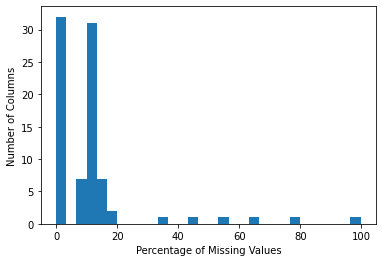

In [20]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(percent_missing_vals_per_column, bins=30)
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Columns')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

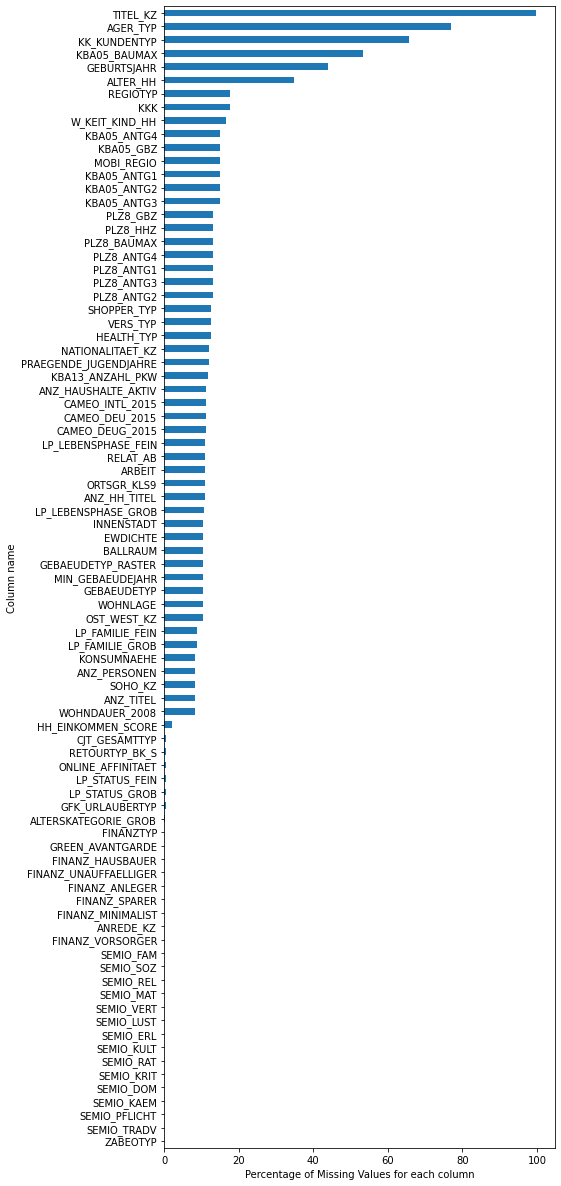

In [21]:
#percent_missing_vals_per_column.plot(kind='barh', figsize = (7,21))
percent_missing_vals_per_column.sort_values(ascending = True, inplace=False).plot(kind='barh', figsize = (7,21))
plt.xlabel('Percentage of Missing Values for each column')
plt.ylabel('Column name')
plt.show

In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Finding the columns that are having more than 20% of the missing values
columns_with_percent_missing_vals_gt_20 = percent_missing_vals_per_column[percent_missing_vals_per_column>20].index.tolist()
print(columns_with_percent_missing_vals_gt_20)

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [23]:
# Removing the outlier columns
azdias_update_1 = azdias_update_1.drop(columns_with_percent_missing_vals_gt_20, axis = 1)

In [24]:
azdias_update_1.shape

(891221, 79)

In [25]:
azdias_update_1.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_FEIN',
       'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'VERS_TYP', 'ZABEOTYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE', 'CAMEO_DEUG_2015',
       'CAMEO

In [26]:
azdias_update_1.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,10.0,0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,NaN,NaN,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,NaN,NaN,NaN,3,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [27]:
assert azdias_update_1.columns.any() not in columns_with_percent_missing_vals_gt_20

In [28]:
#Removing dropped columns features from feat_info

feat_info_index_list = feat_info.isin (columns_with_percent_missing_vals_gt_20) 
feat_info_update_1 = feat_info.drop (feat_info_index_list[feat_info_index_list.attribute == True].index)

#feat_info_update_2 = feat_info.set_index('attribute').drop(columns_with_percent_missing_vals_gt_20).reset_index()

print(feat_info_update_1)

                attribute information_level         type missing_or_unknown
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical               [-1]
12        GFK_URLAUBERTYP            person  categorical                 []
13       GREEN_AVANTGARDE            person  categorical                 []
14          

#### Discussion 1.1.2: Assess Missing Data in Each Column

The coulmns with more than 20% missing data have been considered as outliers and removed from the general population dataframe. The column ids are given below and the information related these column ids have ben removed from feature information dataframe as well

['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

517045     0
411230     0
252730     1
233415    15
409998     0
152903     0
83957      5
856292     0
805054     0
177620     5
dtype: int64

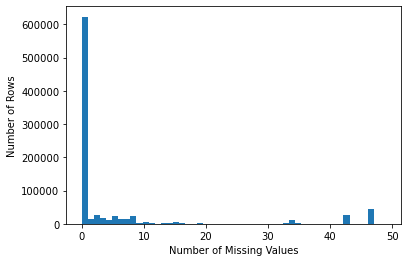

In [29]:
# How much data is missing in each row of the dataset?

missing_vals_per_row = azdias_update_1.isnull().sum(axis=1)
display (missing_vals_per_row.sample(n=10, random_state=0))

plt.hist(missing_vals_per_row, bins=50)
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.show()

In [30]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# Dividing the data into two subsets one with missing values less than or equal to 10 and the 
# other with missing values greater than 10
missing_vals_per_row_le_10 = azdias_update_1[azdias_update_1.isnull().sum(axis=1) <= 10]
missing_vals_per_row_gt_10 = azdias_update_1[azdias_update_1.isnull().sum(axis=1) > 10]

In [31]:
print(missing_vals_per_row_le_10.shape) #shape of the subset with missing values less than or equal to 10

(780153, 79)


In [32]:
print(missing_vals_per_row_gt_10.shape) # shape of the subset one with missing values greater than 10

(111068, 79)


In [33]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

# Getting the list of 5 columns where the there are no missing values
missing_vals_per_column_eq_0 = percent_missing_vals_per_column[percent_missing_vals_per_column == 0].index.tolist()[:5]

print(missing_vals_per_column_eq_0)

['ANREDE_KZ', 'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER']


In [34]:
# function to compare missing values between two subsets for a specified column

def missing_val_comp_two_subsets(df1_missi_le_10, df2_missi_gt_10, column_name):
    fig, axes =plt.subplots(nrows = 1, ncols = 2, figsize = (10,3))
    
    sns.countplot(df1_missi_le_10[column_name], ax=axes[0])
    axes[0].set_title(label = 'Missing values per row less than or equal to 10')
    
    sns.countplot(df2_missi_gt_10[column_name], ax=axes[1])
    axes[1].set_title('Missing values per row greater than 10')
    
    plt.subplots_adjust(hspace = 1, wspace= 0.5)
    fig.show()
    return

C:\Users\Admin_22002\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Admin_22002\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Admin_22002\AppData\Local\Temp\ipykernel_22572\2075324771.py:13: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
C:\Users\Admin_22002\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following vari

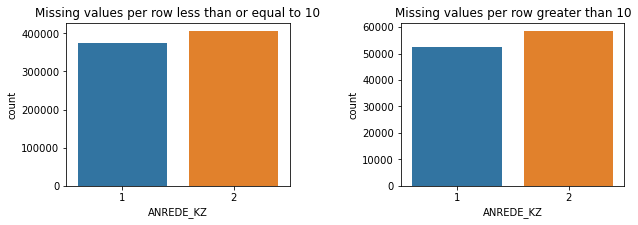

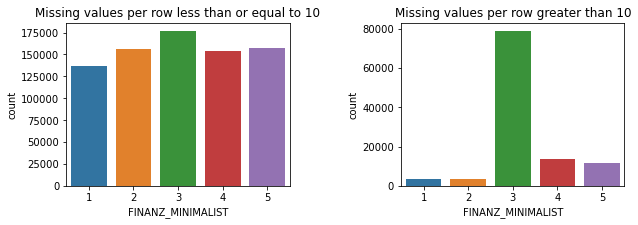

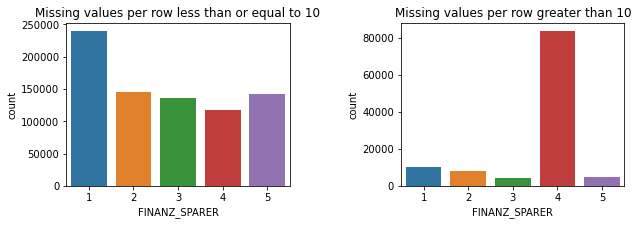

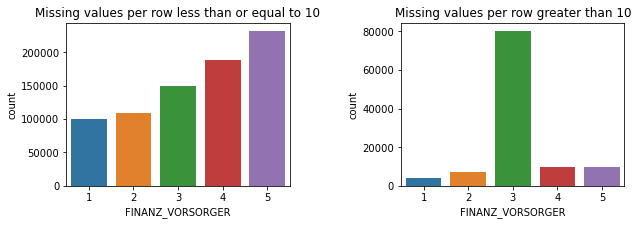

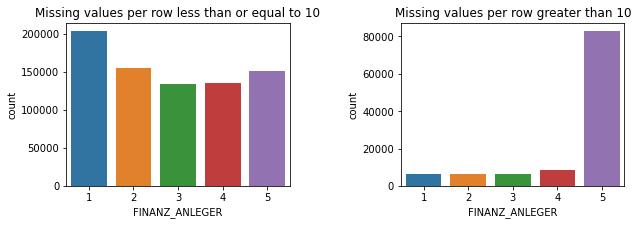

In [35]:
# Applying the function to compare two subsets, loop through the 5 columns where the there are no missing values
for i in range (len(missing_vals_per_column_eq_0)):
    missing_val_comp_two_subsets(missing_vals_per_row_le_10, missing_vals_per_row_gt_10, missing_vals_per_column_eq_0[i])

In [36]:
# creating  a new general population dataframe, considering only the rows with missing values less than 10 in each row
azdias_update_2 = missing_vals_per_row_le_10.copy()

#### Discussion 1.1.3: Assess Missing Data in Each Row

The dataset is divided into 2 subsets one with missing values less than or equal 10 per row and the other with missing values greater than 10 per row.
The dataset with missing values less than 10 per row has been considered for the subsequent analysis in this project.

Also compared the distribution of values for 5 columns for these two subsets. The distributions of values are similar for Gender feature, but are significantly different for the other features considered. This makes the subset with missing values greater than 10 per row needs to be considered as a specifical cluster in the later part of the analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [37]:
# How many features are there of each data type?

number_of_features = feat_info_update_1['type'].value_counts()
display (number_of_features)

ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [38]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

categorical_features = feat_info_update_1[feat_info_update_1['type'] == 'categorical'] ['attribute']
display(categorical_features)

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [39]:
# Printing the unique values in the categorical values
for item in categorical_features:
    print('Unique values for "{}" are {}'.format(item, azdias_update_2[item].unique()))

Unique values for "ANREDE_KZ" are [2 1]
Unique values for "CJT_GESAMTTYP" are [ 5.  3.  2.  4.  1.  6. nan]
Unique values for "FINANZTYP" are [1 6 5 2 4 3]
Unique values for "GFK_URLAUBERTYP" are [10.  1.  5. 12.  9.  3.  8. 11.  4.  7.  2.  6. nan]
Unique values for "GREEN_AVANTGARDE" are [0 1]
Unique values for "LP_FAMILIE_FEIN" are [ 5.  1. nan 10.  2.  7. 11.  8.  4.  6.  9.  3.]
Unique values for "LP_FAMILIE_GROB" are [ 3.  1. nan  5.  2.  4.]
Unique values for "LP_STATUS_FEIN" are [ 2.  3.  9.  4.  1. 10.  5.  8.  6.  7. nan]
Unique values for "LP_STATUS_GROB" are [ 1.  2.  4.  5.  3. nan]
Unique values for "NATIONALITAET_KZ" are [ 1.  3.  2. nan]
Unique values for "SHOPPER_TYP" are [ 3.  2.  1.  0. nan]
Unique values for "SOHO_KZ" are [1. 0.]
Unique values for "VERS_TYP" are [ 2.  1. nan]
Unique values for "ZABEOTYP" are [5 3 4 1 6 2]
Unique values for "GEBAEUDETYP" are [8. 1. 3. 2. 6. 4. 5.]
Unique values for "OST_WEST_KZ" are ['W' 'O']
Unique values for "CAMEO_DEUG_2015" are [

In [40]:
#The feature 'OST_WEST_KZ' has strings 'O' and 'W', this is replaced with 0 and 1 respectively
azdias_update_2.OST_WEST_KZ = azdias_update_2.OST_WEST_KZ.replace ({'O': 0.0,'W': 1.0})

azdias_update_2['OST_WEST_KZ'].unique()

array([1., 0.])

In [41]:
# ientifying the binary and multi level feature categorical variables programatically
categ_binary_feature = []  
categ_multi_level_feature=[]
for item in categorical_features:
    unique_vals = len(azdias_update_2[item].unique())
    if (unique_vals == 2): # binary feature, which has 2 unique values
        categ_binary_feature.append(item)
    elif (unique_vals > 2): # multi level feature, which has more than 2 unique values
        categ_multi_level_feature.append(item)

In [42]:
# printing binary features
print(categ_binary_feature)

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']


In [43]:
# printing multi level features
print(categ_multi_level_feature)

['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [44]:
# Re-encode categorical variable(s) to be kept in the analysis.
azdias_update_3 = pd.get_dummies(azdias_update_2,columns = categ_multi_level_feature)

In [45]:
azdias_update_3.shape

(780153, 195)

#### Discussion 1.2.1: Re-Encode Categorical Features

The binary categorical features are retained fro the analysis. <br>
The strings in the binary categorical feature 'OST_WEST_KZ' has been replaced to numeric values. <br>
Used OneHotEncoder for the multi level categorical features for the analysis.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [46]:
mixed_features = feat_info_update_1[feat_info_update_1['type'] == 'mixed'] ['attribute']
display(mixed_features)

15      LP_LEBENSPHASE_FEIN
16      LP_LEBENSPHASE_GROB
22    PRAEGENDE_JUGENDJAHRE
56                 WOHNLAGE
59          CAMEO_INTL_2015
79              PLZ8_BAUMAX
Name: attribute, dtype: object

In [47]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

'''
From 'Data_Dictionary.md'
### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)
'''


azdias_update_3['PRAEGENDE_JUGENDJAHRE_decade'] = azdias_update_3['PRAEGENDE_JUGENDJAHRE']
azdias_update_3['PRAEGENDE_JUGENDJAHRE_movement'] = azdias_update_3['PRAEGENDE_JUGENDJAHRE']

In [48]:
decade_dict = {1: 40.0, 2: 40.0, 3: 50.0, 4: 50.0, 5: 60.0, 6: 60.0, 7: 60.0, \
                8: 70.0, 9: 70.0, 10: 80.0, 11: 80.0, 12: 80.0, 13: 80.0, 14: 90.0, 15: 90.0,}

In [49]:
# 1 for Mainstream and 0 for Avantgarde
movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [50]:
azdias_update_3['PRAEGENDE_JUGENDJAHRE_decade'] = azdias_update_3['PRAEGENDE_JUGENDJAHRE_decade'].replace(decade_dict)
azdias_update_3['PRAEGENDE_JUGENDJAHRE_movement'].replace(movement_dict, inplace=True)

In [51]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

'''
### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown
'''

azdias_update_3['CAMEO_INTL_2015_wealth'] = azdias_update_3['CAMEO_INTL_2015']
azdias_update_3['CAMEO_INTL_2015_life_LIFE_STAGE'] = azdias_update_3['CAMEO_INTL_2015']

In [52]:
wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, \
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, \
               '51':5, '52':5, '53':5, '54':5, '55':5}

life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, \
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, \
                   '51':1, '52':2, '53':3, '54':4, '55':5}

In [53]:
azdias_update_3['CAMEO_INTL_2015_wealth'].replace(wealth_dict, inplace=True)
azdias_update_3['CAMEO_INTL_2015_life_LIFE_STAGE'].replace(life_stage_dict, inplace=True)

In [54]:
azdias_update_3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Columns: 199 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_life_LIFE_STAGE
dtypes: float64(46), int64(22), object(1), uint8(130)
memory usage: 513.4+ MB


In [55]:
azdias_update_4 = azdias_update_3.copy()

In [56]:
azdias_update_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Columns: 199 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_life_LIFE_STAGE
dtypes: float64(46), int64(22), object(1), uint8(130)
memory usage: 513.4+ MB


#### Discussion 1.2.2: Engineer Mixed-Type Features

Identified tootal 6 mixed type features. <br>
The following features have been re-encoded <br>
PRAEGENDE_JUGENDJAHRE <br>
CAMEO_INTL_2015 <br>

The following 4 have been removed.<br>
LP_LEBENSPHASE_FEIN <br>
LP_LEBENSPHASE_GROB <br>
WOHNLAGE <br>
PLZ8_BAUMAX <br>

Re-encoding for PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015:<br>
Created two new feature columns for each, and copied values from the initial mixed value feature column<br>
Created two dictionaries for each to map intial feature values to new feature values<br>
The new feature columns are replaced with the two dictionaries and the original columns (PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015) have been removed<br>

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [57]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# droping the mixed features
azdias_update_4.drop (mixed_features, axis = 1, inplace = True)

In [58]:
azdias_update_4.shape

(780153, 193)

In [59]:
# checking
assert azdias_update_4.columns.any() not in mixed_features

In [60]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [61]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
        
    # Put in code here to execute all main cleaning steps:
    
    # convert missing or unknown value codes into NaNs using the 'missing_data_list' already created
    #-----------------------------------------------------------------------------------------------
    for missing_list in range (len (missing_data_list)): 
        column_id = feat_info.iloc [missing_list] ['attribute'] #saving column name
        df[column_id].replace (to_replace = missing_data_list[missing_list], value = np.NaN, regex = True, inplace = True)
        

    # dropping outlier columns with more than 20% of the missing values    
    #-------------------------------------------------------------------
#    percent_missing_vals_per_column =(df.isnull().sum()/df.shape[0])*100
    # Finding the columns that are having more than 20% of the missing values
#    columns_with_percent_missing_vals_gt_20 = percent_missing_vals_per_column[percent_missing_vals_per_column>20].index.tolist()

    # Removing the outlier columns
    df = df.drop(columns_with_percent_missing_vals_gt_20, axis = 1)
    
    #storing number of dropped rows and returining from function
    removed_rows = df[df.isnull().sum(axis=1) > 10].shape[0]
    
    # removing the rows with missing values greater than 10 in each row
    df = df[df.isnull().sum(axis=1) <= 10]   
   
    
    # select, re-encode, and engineer column values.
    
    # identifying the categorical features
    categorical_features = feat_info_update_1[feat_info_update_1['type'] == 'categorical'] ['attribute']
    
            
    #The feature 'OST_WEST_KZ' has strings 'O' and 'W', this is replaced with 0 and 1 respectively
    df.OST_WEST_KZ = df.OST_WEST_KZ.replace ({'O': 0.0,'W': 1.0})
    
    # ientifying the binary and multi level feature categorical variables programatically
    categ_binary_feature = []
    categ_multi_level_feature=[]
    for item in categorical_features:
        unique_vals = len(df[item].unique())
        if (unique_vals == 2):
            categ_binary_feature.append(item)
        elif (unique_vals > 2):
            categ_multi_level_feature.append(item)
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    df = pd.get_dummies(df,columns = categ_multi_level_feature)

    
    # mixed features
    mixed_features = feat_info_update_1[feat_info_update_1['type'] == 'mixed'] ['attribute']
    
    
    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE']
    df['PRAEGENDE_JUGENDJAHRE_movement'] = df['PRAEGENDE_JUGENDJAHRE']

    decade_dict = {1: 40.0, 2: 40.0, 3: 50.0, 4: 50.0, 5: 60.0, 6: 60.0, 7: 60.0, \
                8: 70.0, 9: 70.0, 10: 80.0, 11: 80.0, 12: 80.0, 13: 80.0, 14: 90.0, 15: 90.0,}

    # 1 for Mainstream and 0 for Avantgarde
    movement_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

    df['PRAEGENDE_JUGENDJAHRE_decade'] = df['PRAEGENDE_JUGENDJAHRE_decade'].replace(decade_dict)
    df['PRAEGENDE_JUGENDJAHRE_movement'].replace(movement_dict, inplace=True)

    # Investigate "CAMEO_INTL_2015" and engineer two new variables.
    df['CAMEO_INTL_2015_wealth'] = df['CAMEO_INTL_2015']
    df['CAMEO_INTL_2015_life_LIFE_STAGE'] = df['CAMEO_INTL_2015']

    wealth_dict = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2, \
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4, \
               '51':5, '52':5, '53':5, '54':5, '55':5}

    life_stage_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5, \
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5, \
                   '51':1, '52':2, '53':3, '54':4, '55':5}


    df['CAMEO_INTL_2015_wealth'].replace(wealth_dict, inplace=True)
    df['CAMEO_INTL_2015_life_LIFE_STAGE'].replace(life_stage_dict, inplace=True)


    # droiping the mixed_features columns
    df.drop (mixed_features, axis = 1, inplace = True)


    # Return the cleaned dataframe.
    return df, removed_rows

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [62]:
azdias_update_4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Columns: 193 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_life_LIFE_STAGE
dtypes: float64(41), int64(22), uint8(130)
memory usage: 477.7 MB


In [63]:
sum(azdias_update_4.isna().sum())

494570

In [64]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
# Filling nans with most frequent values using SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
azdias_update_5 = pd.DataFrame(imputer.fit_transform(azdias_update_4))

In [65]:
sum(azdias_update_5.isna().sum())

0

In [66]:
azdias_update_5.columns = azdias_update_4.columns
azdias_update_5.index = azdias_update_4.index

In [67]:
azdias_update_5.head(2)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,CJT_GESAMTTYP_1.0,CJT_GESAMTTYP_2.0,CJT_GESAMTTYP_3.0,CJT_GESAMTTYP_4.0,CJT_GESAMTTYP_5.0,CJT_GESAMTTYP_6.0,FINANZTYP_1,FINANZTYP_2,FINANZTYP_3,FINANZTYP_4,FINANZTYP_5,FINANZTYP_6,GFK_URLAUBERTYP_1.0,GFK_URLAUBERTYP_2.0,GFK_URLAUBERTYP_3.0,GFK_URLAUBERTYP_4.0,GFK_URLAUBERTYP_5.0,GFK_URLAUBERTYP_6.0,GFK_URLAUBERTYP_7.0,GFK_URLAUBERTYP_8.0,GFK_URLAUBERTYP_9.0,GFK_URLAUBERTYP_10.0,GFK_URLAUBERTYP_11.0,GFK_URLAUBERTYP_12.0,LP_FAMILIE_FEIN_1.0,LP_FAMILIE_FEIN_2.0,LP_FAMILIE_FEIN_3.0,LP_FAMILIE_FEIN_4.0,LP_FAMILIE_FEIN_5.0,LP_FAMILIE_FEIN_6.0,LP_FAMILIE_FEIN_7.0,LP_FAMILIE_FEIN_8.0,LP_FAMILIE_FEIN_9.0,LP_FAMILIE_FEIN_10.0,LP_FAMILIE_FEIN_11.0,LP_FAMILIE_GROB_1.0,LP_FAMILIE_GROB_2.0,LP_FAMILIE_GROB_3.0,LP_FAMILIE_GROB_4.0,LP_FAMILIE_GROB_5.0,LP_STATUS_FEIN_1.0,LP_STATUS_FEIN_2.0,LP_STATUS_FEIN_3.0,LP_STATUS_FEIN_4.0,LP_STATUS_FEIN_5.0,LP_STATUS_FEIN_6.0,LP_STATUS_FEIN_7.0,LP_STATUS_FEIN_8.0,LP_STATUS_FEIN_9.0,LP_STATUS_FEIN_10.0,LP_STATUS_GROB_1.0,LP_STATUS_GROB_2.0,LP_STATUS_GROB_3.0,LP_STATUS_GROB_4.0,LP_STATUS_GROB_5.0,NATIONALITAET_KZ_1.0,NATIONALITAET_KZ_2.0,NATIONALITAET_KZ_3.0,SHOPPER_TYP_0.0,SHOPPER_TYP_1.0,SHOPPER_TYP_2.0,SHOPPER_TYP_3.0,VERS_TYP_1.0,VERS_TYP_2.0,ZABEOTYP_1,ZABEOTYP_2,ZABEOTYP_3,ZABEOTYP_4,ZABEOTYP_5,ZABEOTYP_6,GEBAEUDETYP_1.0,GEBAEUDETYP_2.0,GEBAEUDETYP_3.0,GEBAEUDETYP_4.0,GEBAEUDETYP_5.0,GEBAEUDETYP_6.0,GEBAEUDETYP_8.0,CAMEO_DEUG_2015_1,CAMEO_DEUG_2015_2,CAMEO_DEUG_2015_3,CAMEO_DEUG_2015_4,CAMEO_DEUG_2015_5,CAMEO_DEUG_2015_6,CAMEO_DEUG_2015_7,CAMEO_DEUG_2015_8,CAMEO_DEUG_2015_9,CAMEO_DEU_2015_1A,CAMEO_DEU_2015_1B,CAMEO_DEU_2015_1C,CAMEO_DEU_2015_1D,CAMEO_DEU_2015_1E,CAMEO_DEU_2015_2A,CAMEO_DEU_2015_2B,CAMEO_DEU_2015_2C,CAMEO_DEU_2015_2D,CAMEO_DEU_2015_3A,CAMEO_DEU_2015_3B,CAMEO_DEU_2015_3C,CAMEO_DEU_2015_3D,CAMEO_DEU_2015_4A,CAMEO_DEU_2015_4B,CAMEO_DEU_2015_4C,CAMEO_DEU_2015_4D,CAMEO_DEU_2015_4E,CAMEO_DEU_2015_5A,CAMEO_DEU_2015_5B,CAMEO_DEU_2015_5C,CAMEO_DEU_2015_5D,CAMEO_DEU_2015_5E,CAMEO_DEU_2015_5F,CAMEO_DEU_2015_6A,CAMEO_DEU_2015_6B,CAMEO_DEU_2015_6C,CAMEO_DEU_2015_6D,CAMEO_DEU_2015_6E,CAMEO_DEU_2015_6F,CAMEO_DEU_2015_7A,CAMEO_DEU_2015_7B,CAMEO_DEU_2015_7C,CAMEO_DEU_2015_7D,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_life_LIFE_STAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0.0,3.0,1.0,5.0,4.0,4.0,3.0,1.0,2.0,2.0,3.0,6.0,4.0,7.0,4.0,7.0,6.0,1.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1.0,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,5.0,4.0,3.0,5.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,1.0,5.0,1.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,3.0,3.0,4.0,

In [68]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler() 
azdias_update_6_scaled = scaler.fit_transform(azdias_update_5)

In [69]:
# creating a dataframe with feature scaled data
azdias_update_6_scaled = pd.DataFrame(azdias_update_6_scaled, columns=list(azdias_update_5))

In [70]:
azdias_update_6_scaled.shape

(780153, 193)

### Discussion 2.1: Apply Feature Scaling

Replaced all the nans with most frequent values in that column using SimpleImputer and all features are scaled using the StandardScaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [71]:
# Apply PCA to the data.

pca = PCA(n_components = 193)
pca.fit(azdias_update_6_scaled)

PCA(n_components=193)

In [72]:
# Investigate the variance accounted for by each principal component.

# PCA components
components_index = ['Component {}'.format(i) for i in range(1,len(pca.components_)+1)]

pca_components = pd.DataFrame(np.round(pca.components_, 4), columns = azdias_update_6_scaled.keys())
pca_components.index = components_index

# PCA explained variance
ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
variance_ratios.index = components_index

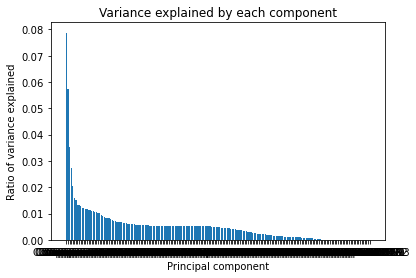

In [73]:
# Investigate the variance accounted for by each principal component.
plt.bar(components_index, pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

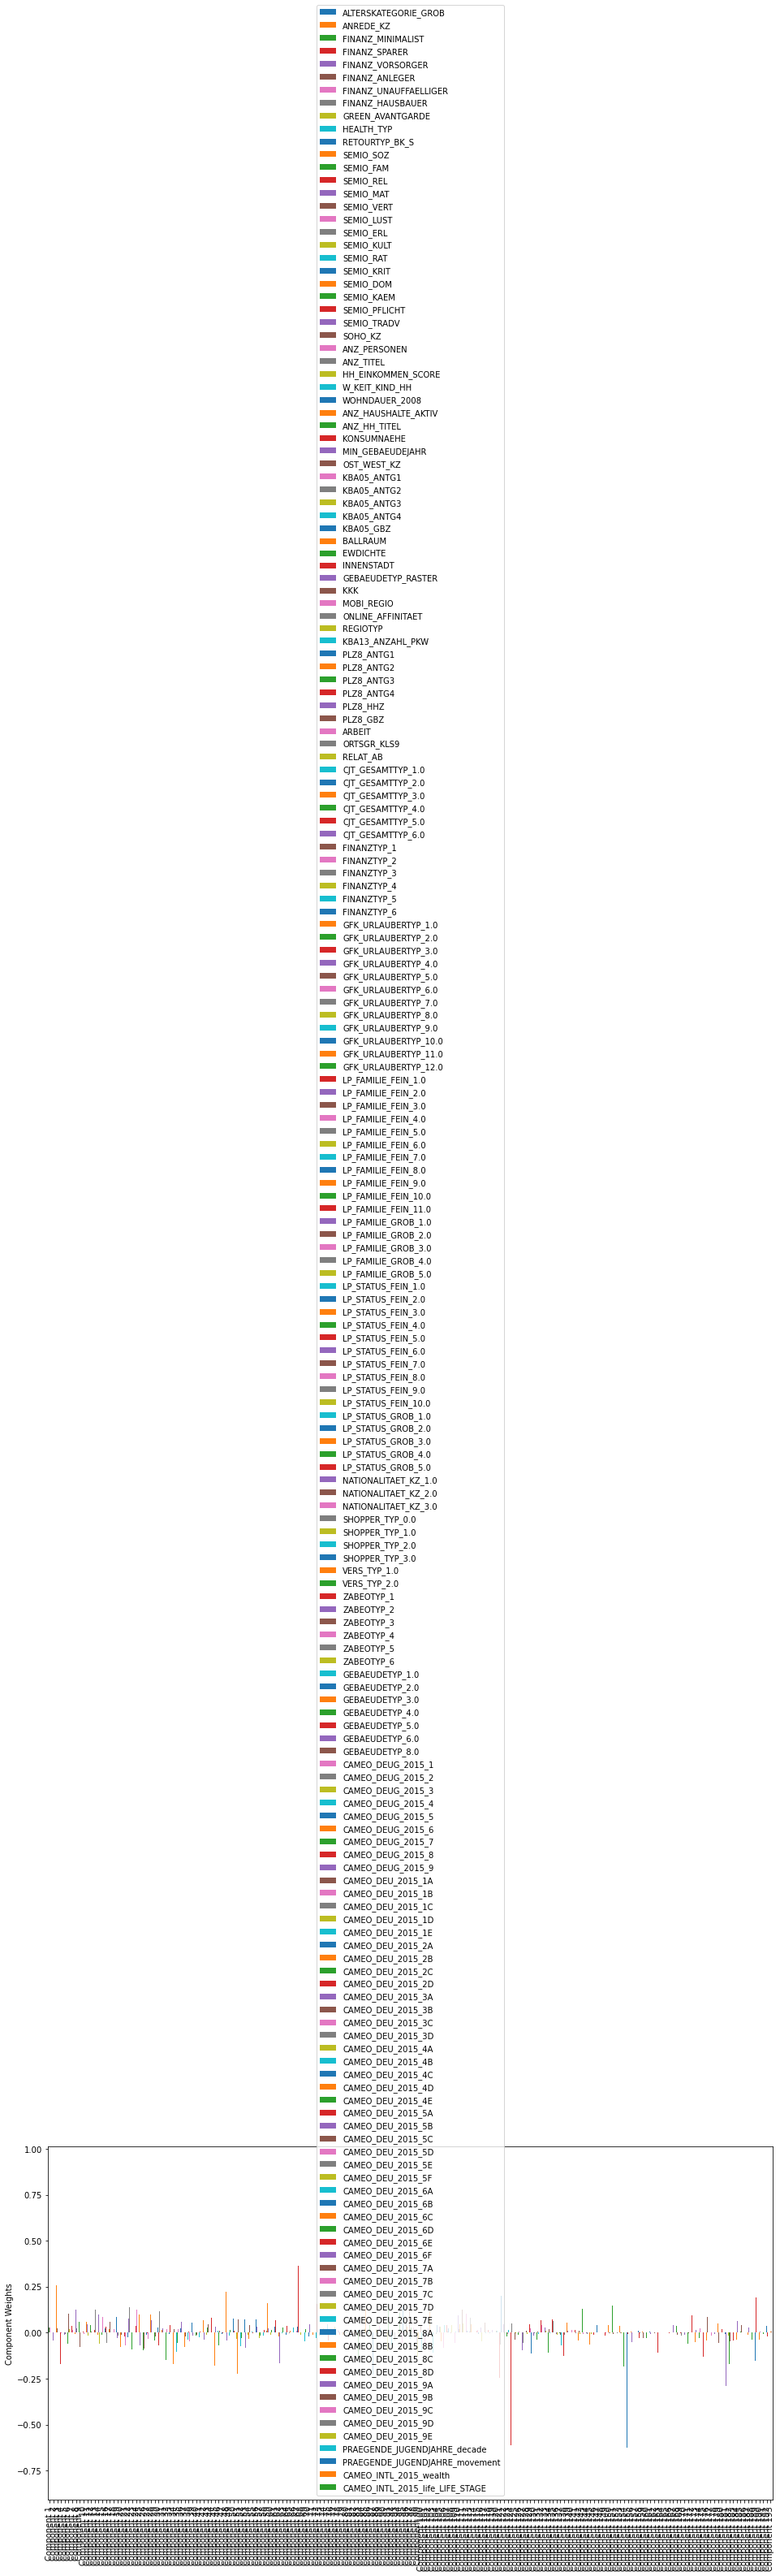

In [74]:
# Plot visualization
fig, axes = plt.subplots(figsize = (16,8))

# Plot Component weights Vs components
pca_components.plot(ax = axes, kind = 'bar');
axes.set_ylabel("Component Weights")
plt.show()

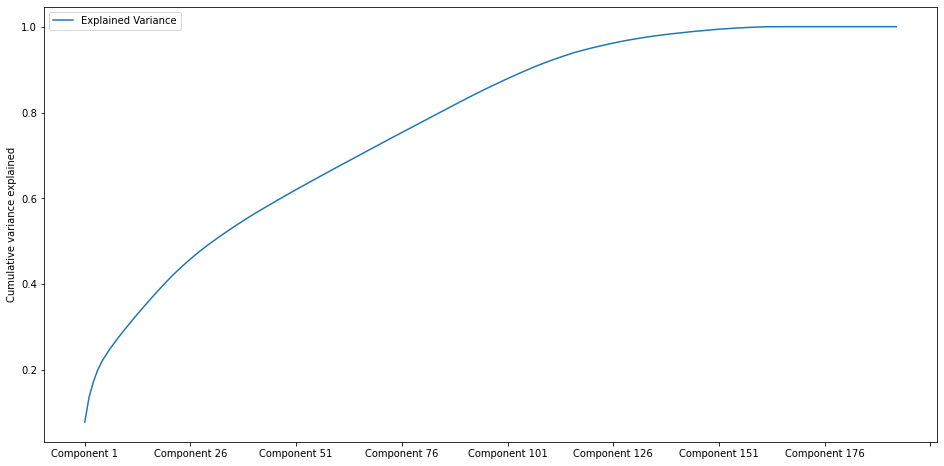

In [75]:
# Plot visualization
fig, axes = plt.subplots(figsize = (16,8))

# Plot Cumulative variance ratio Vs components
cumval_variance_ratios = np.cumsum(variance_ratios)
cumval_variance_ratios.plot(ax=axes, kind='line')
axes.set_ylabel("Cumulative variance explained")
plt.show()

In [76]:
#print(pca_components)

In [77]:
# Re-apply PCA to the data while selecting for number of components to retain.
# Number of feature components selected as 75
pca_75 = PCA(n_components=75)
azdias_update_6_scaled_pca_75 = pca_75.fit_transform(azdias_update_6_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

Considered to retain 75 principal components, as it explains more than 75% variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [78]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def pca_map_weights(df, principal_component_num, num_of_features, show_plot=True, pca = pca_75):
    
    pca_comp_weights = pd.DataFrame(np.round(pca.components_, 6), columns=df.keys()).iloc[principal_component_num - 1]
    pca_comp_weights.sort_values(ascending=False, inplace=True)
    pca_comp_weights = pd.concat([pca_comp_weights.head(num_of_features), pca_comp_weights.tail(num_of_features)])
    
    if show_plot:
        # Plot the result
        pca_comp_weights.plot(kind='bar', 
                  title='Most {} weighted features for PCA component {}'.format(num_of_features*2, principal_component_num),
                  figsize=(14, 7))
        plt.show()
    
    return pca_comp_weights

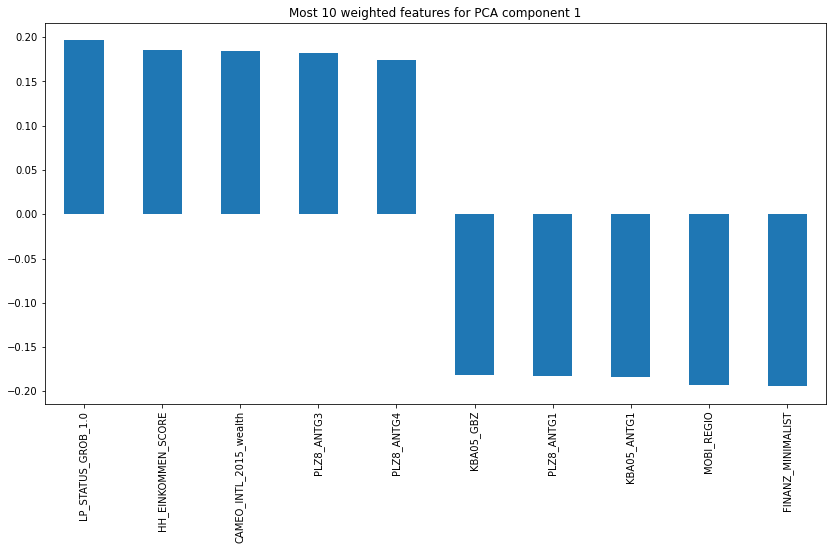

LP_STATUS_GROB_1.0        0.196466
HH_EINKOMMEN_SCORE        0.185949
CAMEO_INTL_2015_wealth    0.184756
PLZ8_ANTG3                0.181710
PLZ8_ANTG4                0.174763
KBA05_GBZ                -0.181192
PLZ8_ANTG1               -0.182565
KBA05_ANTG1              -0.183831
MOBI_REGIO               -0.192890
FINANZ_MINIMALIST        -0.194292
Name: 0, dtype: float64


In [79]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_weight_first_pc = pca_map_weights(azdias_update_6_scaled, 1, 5)
print (pca_weight_first_pc)

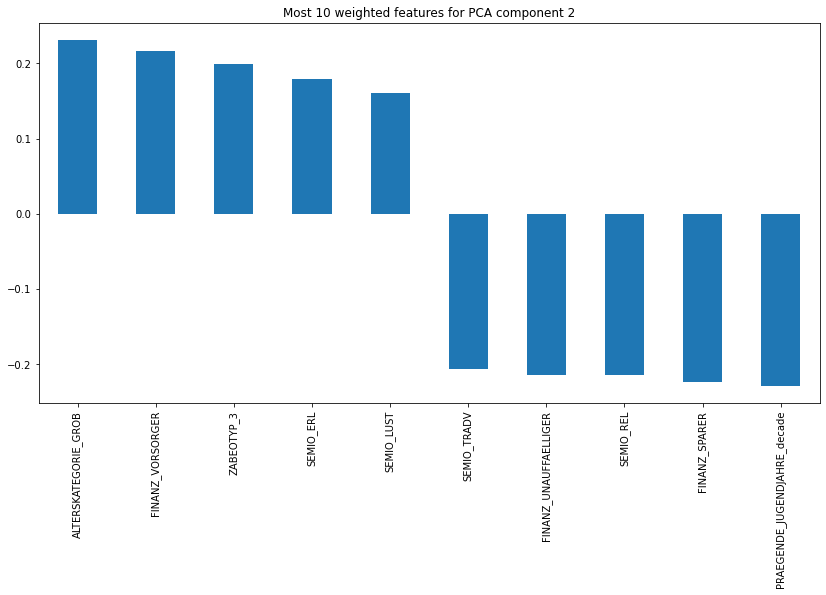

ALTERSKATEGORIE_GROB            0.230903
FINANZ_VORSORGER                0.216602
ZABEOTYP_3                      0.199743
SEMIO_ERL                       0.179663
SEMIO_LUST                      0.160754
SEMIO_TRADV                    -0.206499
FINANZ_UNAUFFAELLIGER          -0.213878
SEMIO_REL                      -0.214522
FINANZ_SPARER                  -0.223940
PRAEGENDE_JUGENDJAHRE_decade   -0.228888
Name: 1, dtype: float64


In [80]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_second_pc = pca_map_weights(azdias_update_6_scaled, 2, 5)
print (pca_weight_second_pc)

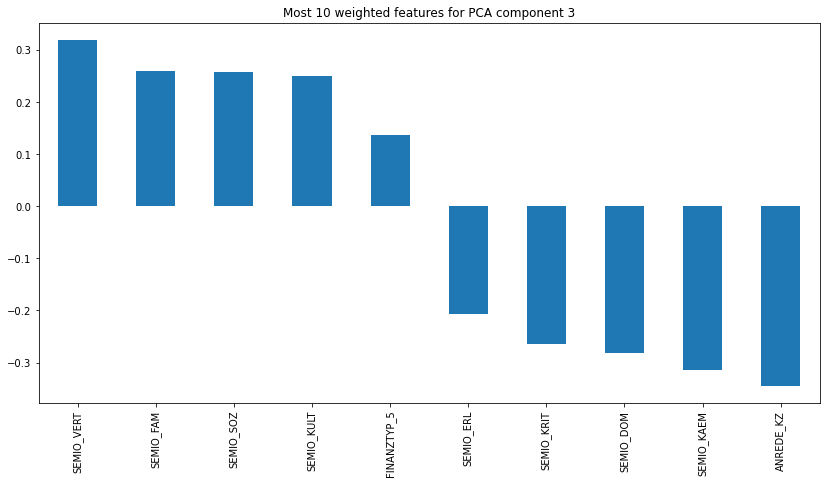

SEMIO_VERT     0.319019
SEMIO_FAM      0.259756
SEMIO_SOZ      0.257649
SEMIO_KULT     0.249787
FINANZTYP_5    0.136587
SEMIO_ERL     -0.207291
SEMIO_KRIT    -0.264847
SEMIO_DOM     -0.281772
SEMIO_KAEM    -0.314274
ANREDE_KZ     -0.344539
Name: 2, dtype: float64


In [81]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_weight_third_pc = pca_map_weights(azdias_update_6_scaled, 3, 5)
print (pca_weight_third_pc)

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

From the first principal component, <br>

The top 5 Positive features: LP_STATUS_GROB_1.0 (Social status, rough scale), HH_EINKOMMEN_SCORE (Estimated household net income), CAMEO_INTL_2015_WL (Wealth of household), PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 region), PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 region)

Three negative features: FINANZ_MINIMALIST (FINANZ MINIMALIST: low financial interest), MOBI_REGIO (Movement patterns), PLZ8_ANTG1 (Number of 1-2 family houses in the PLZ8 region).

The important factors are social status, income, number of 6-10 family houses in the PLZ8 region, wealth of the household, number of 10+ family houses in the PLZ8 region, movement level in the region. It can be seen that the increases in 1-2 family houses will lead to decreases 6-10 family houses which seems sensible and confirmed by PCA.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [82]:
# Over a number of different cluster counts...


    # run k-means clustering on the data and...
    
    
    # compute the average within-cluster distances.

k_means_scores = []
clusters_range = np.array([3,8,13,18,23,25,27,28,29,30])
#clusters_range = np.array([3])
for i in clusters_range:
    model = KMeans(i,random_state=42)
    model.fit(azdias_update_6_scaled_pca_75)
    k_means_scores.append(abs(model.score(azdias_update_6_scaled_pca_75)))
    print(f'Score for {i} Clusters: {abs(model.score(azdias_update_6_scaled_pca_75)):.1f}')

Score for 3 Clusters: 98469098.2
Score for 8 Clusters: 89143720.6
Score for 13 Clusters: 85193161.9
Score for 18 Clusters: 82378415.8
Score for 23 Clusters: 79877930.3
Score for 25 Clusters: 79006388.9
Score for 27 Clusters: 77916924.6
Score for 28 Clusters: 77404755.1
Score for 29 Clusters: 77422997.3
Score for 30 Clusters: 77323305.1


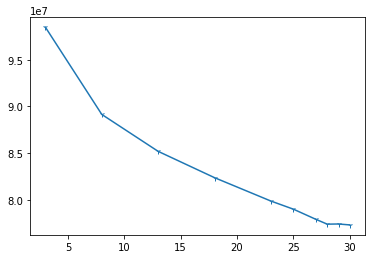

In [83]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
#clusters_range1 = np.array([3,8,13,18,23,24,25,26,27,28,29,30])
plt.plot(clusters_range,k_means_scores,marker="1")
plt.show()


In [84]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

kmeans_model_28_cluss_final_model = KMeans(n_clusters = 28, random_state=42)
model_28_clus = kmeans_model_28_cluss_final_model.fit(azdias_update_6_scaled_pca_75)
azdias_pred_gen_popul = model_28_clus.predict(azdias_update_6_scaled_pca_75)

### Discussion 3.1: Apply Clustering to General Population

From the above assessment and plot, it seems the elbow is forming when the number of clusters = 28. So, 28 clusters have been considered for the analysis.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [85]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep = ';')

In [86]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,2,0,4.0,1,1,20.0,5.0,2.0,2.0,10.0,5.0,1,4,5.0,6,5,2,6,6,7,3,4,1,3,1,1,2,1,3,0.0,0.0,1,3,10.0,2.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,1.0,5.0,1992.0,W,7.0,1,1A,13,2.0,2.0,0.0,0.0,0.0,4.0,3.0,2.0,4.0,4.0,1.0,4.0,3.0,1.0,1201.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,2,0,NaN,0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,0,NaN,3,6,2,6,7,5,3,4,1,3,3,2,4,1,3,0.0,0.0,1,3,11.0,3.0,0.0,NaN,NaN,0.0,9.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,2,0,3.0,1,2,13.0,3.0,1.0,1.0,10.0,5.0,1,4,5.0,2,2,1,3,3,7,7,1,2,7,5,6,4,1,1,0.0,0.0,2,3,6.0,1.0,0.0,1.0,NaN,6.0,9.0,1.0,0.0,8.0,1.0,1992.0,W,2.0,5,5D,34,2.0,2.0,0.0,0.0,0.0,3.0,7.0,4.0,1.0,3.0,3.0,3.0,1.0,7.0,433.0,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,6,0,10.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,1,3.0,6,5,3,4,7,5,3,4,3,3,3,3,3,4,0,0.0,0.0,1,1,8.0,0.0,0.0,4.0,NaN,NaN,9.0,0.0,NaN,2.0,2.0,1992.0,W,7.0,4,4C,24,3.0,0.0,0.0,0.0,1.0,4.0,7.0,1.0,7.0,4.0,3.0,4.0,2.0,6.0,755.0,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,2,1960,2.0,0,3,31.0,10.0,10.0,5.0,1.0,1.0,1,8,5.0,4,5,4,6,5,6,4,5,5,3,5,2,5,4,1,0.0,0.0,2,1,20.0,4.0,0.0,6.0,2.0,2.0,9.0,7.0,0.0,3.0,1.0,1992.0,W,3.0,7,7B,41,0.0,3.0,2.0,0.0,0.0,3.0,3.0,4.0,4.0,3.0,4.0,3.0,5.0,7.0,513.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [87]:
#double checking the output of the function 'clean_data'

temp_2,dummy = clean_data(azdias)
temp_2.equals(azdias_update_5)

False

In [88]:
del temp_2

In [89]:
customers_clean,removed_rows = clean_data(customers)

In [90]:
customers_clean.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B',
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E',
       'PRAEGENDE_JUGENDJAHRE_decade', 'PRAEGENDE_JUGENDJAHRE_movement',
       'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_life_LIFE_STAGE'],
      dtype='object', length=192)

In [91]:
customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139068 entries, 0 to 191651
Columns: 192 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_life_LIFE_STAGE
dtypes: float64(41), int64(22), uint8(129)
memory usage: 85.0 MB


In [92]:
azdias_update_5.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780153 entries, 1 to 891220
Columns: 193 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_life_LIFE_STAGE
dtypes: float64(193)
memory usage: 1.1 GB


In [93]:
# missing couln in customers dataframe
for i in azdias_update_5.columns:
    if i not in customers_clean.columns:
        print(i)

GEBAEUDETYP_5.0


In [94]:
# Finding the location of the missing column in the general poulation dataframe
columns = azdias_update_5.columns
column_index = columns.get_loc('GEBAEUDETYP_5.0')
print(column_index)

133


In [95]:
# inserting the missing column in the customers dataframe
customers_clean.insert (loc = column_index, column = 'GEBAEUDETYP_5.0', value = 0)

In [96]:
# checking
customers_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 139068 entries, 0 to 191651
Columns: 193 entries, ALTERSKATEGORIE_GROB to CAMEO_INTL_2015_life_LIFE_STAGE
dtypes: float64(41), int64(23), uint8(129)
memory usage: 86.1 MB


In [97]:
columns_customers_clean = customers_clean.columns

In [98]:
columns_customers_clean.equals(columns)

True

In [99]:
#imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
#azdias_update_5 = pd.DataFrame(imputer.fit_transform(azdias_update_4))

# SimpleImputer and Scaling

customers_clean_imput = imputer.transform(customers_clean)
customers_clean_imput_scal = scaler.transform(customers_clean_imput)
customers_clean_imput_scal_df = pd.DataFrame(customers_clean_imput_scal, columns=list(columns_customers_clean))

C:\Users\Admin_22002\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [100]:
# fit pca
customers_clean_scaled_pca = pca_75.transform(customers_clean_imput_scal_df)

In [101]:
#predictions
customers_clean_pred = model_28_clus.predict(customers_clean_scaled_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [102]:
# Adding the dropped rows as cluster 29 - in the customers predictions
# customers_clean_pred_withadd_remo_rows = np.array([])
customers_clean_pred_add_rows = customers_clean_pred.copy()

for i in range(removed_rows):
    customers_clean_pred_add_rows = np.append(customers_clean_pred_add_rows, 28)

#print(customers_clean.shape[0])
#print("removed rows = ", removed_rows)
#print(len(customers_clean_pred_add_rows))
#print(len(customers_clean_pred))


In [103]:
# Adding the dropped rows as cluster 29 - in the general populations predictions
# customers_clean_pred_withadd_remo_rows = np.array([])

num_rows = missing_vals_per_row_gt_10.shape[0]

azdias_pred_gen_popul_add_rows = azdias_pred_gen_popul.copy()

for i in range(num_rows):
    azdias_pred_gen_popul_add_rows = np.append(azdias_pred_gen_popul_add_rows, 28)

#print(azdias_update_1.shape[0])
#print("removed rows = ", num_rows)
#print(len(azdias_pred_gen_popul_add_rows))
#print(len(azdias_pred_gen_popul))

In [104]:
#r1 = Counter(customers_clean_pred_add_rows).items()
#for keys,values in r1:
#    print(keys,values)

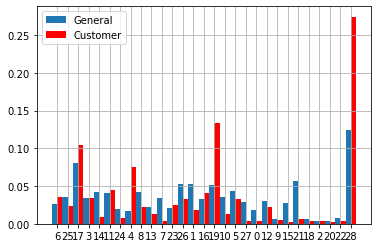

In [105]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# source: https://knowledge.udacity.com/questions/905904

from collections import Counter
# generating proportion for the customer clusters.
labels, values = zip(*Counter(customers_clean_pred_add_rows).items())
v=list(values)
v[:] = [x/len(customers_clean_pred_add_rows) for x in v]
indexes = np.arange(len(labels))
# generating proportion for the azdias clusters.
labels1, values1 = zip(*Counter(azdias_pred_gen_popul_add_rows).items())
v1=list(values1)
v1[:] = [x/len(azdias_pred_gen_popul_add_rows) for x in v1]
indexes1 = np.arange(len(labels))
# configuring the graph
width = .5
plt.bar(indexes1, v1, width ,label='General')
plt.bar(indexes+width, v, width,  color='r' , label='Customer')
plt.xticks(indexes + width * 0.5, labels)
plt.legend(loc='upper left')
plt.grid()
plt.show()

C:\Users\Admin_22002\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Admin_22002\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Customers Clusters')

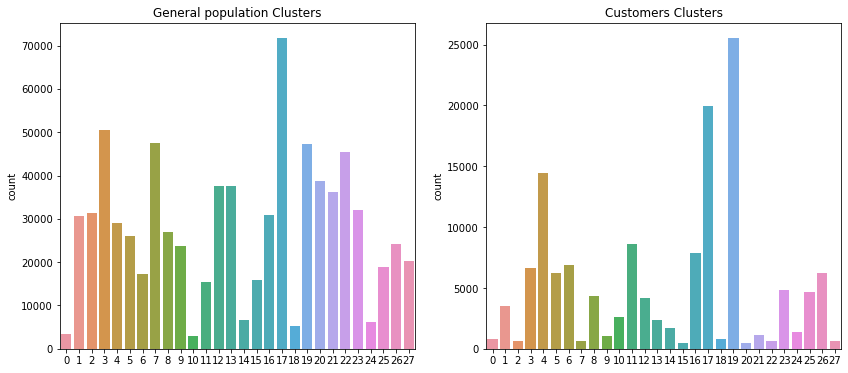

In [106]:
# More visualisations

figure, axes = plt.subplots(nrows=1, ncols=2, figsize = (14,6))

sns.countplot(azdias_pred_gen_popul, ax=axes[0])
axes[0].set_title('General population Clusters')
sns.countplot(customers_clean_pred, ax=axes[1])
axes[1].set_title('Customers Clusters')


In [107]:
azdias_pred_df = pd.DataFrame (azdias_pred_gen_popul, columns = ['General_population_clusters'])

azdias_prop_of_data_points = pd.DataFrame (azdias_pred_df.General_population_clusters.value_counts())/ (azdias_update_1.shape[0]) * 100


#number of dropped rows where missing values more than 10 in a row 
azdias_drop_number = (missing_vals_per_row_gt_10.shape [0])/ (azdias_update_1.shape[0]) * 100


#adding dropped rows as separate cluster
dropped_rows_new_clust = pd.Series ([azdias_drop_number], index = ['General_population_clusters'])
azdias_prop_of_data_points = azdias_prop_of_data_points.append (dropped_rows_new_clust, ignore_index=True)

azdias_prop_of_data_points.sort_index (inplace = True)
display (azdias_prop_of_data_points)

C:\Users\Admin_22002\AppData\Local\Temp\ipykernel_22572\11324035.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  azdias_prop_of_data_points = azdias_prop_of_data_points.append (dropped_rows_new_clust, ignore_index=True)


,General_population_clusters
0,8.045704
1,5.677492
2,5.339304
3,5.307999
4,5.108609
5,4.358739
6,4.216126
7,4.213209
8,4.053428
9,3.604830


In [108]:
customers_pred_df = pd.DataFrame (customers_clean_pred, columns = ['Customers_clusters'])

customers_prop_of_data_points = pd.DataFrame (customers_pred_df.Customers_clusters.value_counts())/ (customers.shape [0]) * 100


#number of dropped rows where missing values were presented in more than 10 fields 
customers_drop_number = (removed_rows)/ (customers.shape [0]) * 100


#adding dropped rows as separate cluster
dropped_rows_new_clust = pd.Series ([customers_drop_number], index = ['Customers_clusters'])
customers_prop_of_data_points = customers_prop_of_data_points.append (dropped_rows_new_clust, ignore_index=True)

customers_prop_of_data_points.sort_index (inplace = True)
display (customers_prop_of_data_points)

C:\Users\Admin_22002\AppData\Local\Temp\ipykernel_22572\3713278303.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  customers_prop_of_data_points = customers_prop_of_data_points.append (dropped_rows_new_clust, ignore_index=True)


,Customers_clusters
0,13.318932
1,10.417841
2,7.518836
3,4.511302
4,4.106923
5,3.588275
6,3.469309
7,3.260076
8,3.241292
9,2.505061


In [117]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Overrepresented cluster: 5
# top 5 principal components of cluster 5
clus_cent_4 = model_28_clus.cluster_centers_[4]
clus_cent_4_df = pd.DataFrame(clus_cent_4,columns=['pca_weights'])

# Sorting the centroid in descending order regardless of the sign

print("top 5 principal components of cluster 5, regardless of sign \n", \
      clus_cent_4_df.reindex(clus_cent_4_df.sort_values('pca_weights',ascending=False,key=abs).index).head(5))

print("top 3 postive principal components \n", \
      clus_cent_4_df.reindex(clus_cent_4_df.sort_values('pca_weights',ascending=False).index).head(3))

print("top 3 negative principal components \n", \
      clus_cent_4_df.reindex(clus_cent_4_df.sort_values('pca_weights',ascending=True).index).head(3))

top 5 principal components of cluster 5, regardless of sign 
     pca_weights
0     -5.232839
3      3.209731
15     1.824412
16     1.806102
5     -1.666637
top 3 postive principal components 
     pca_weights
3      3.209731
15     1.824412
16     1.806102
top 3 negative principal components 
    pca_weights
0    -5.232839
5    -1.666637
7    -1.483915


In [118]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# Transform cluster 5 to original feature values

centroid_4_temp1 = scaler.inverse_transform((pca_75.inverse_transform(model_28_clus.cluster_centers_[4]).reshape(1,-1)))
centroid_4_temp2 = np.transpose(centroid_4_temp1)
centroid_4 = centroid_4_temp2[:,0]

over_represented_cluster = pd.Series(data = centroid_4, index = customers_clean.columns)

print(over_represented_cluster)

ALTERSKATEGORIE_GROB                  3.207272
ANREDE_KZ                             1.496896
FINANZ_MINIMALIST                     4.505867
FINANZ_SPARER                         1.766706
FINANZ_VORSORGER                      4.047713
FINANZ_ANLEGER                        1.971873
FINANZ_UNAUFFAELLIGER                 2.279604
FINANZ_HAUSBAUER                      2.041087
GREEN_AVANTGARDE                      0.964179
HEALTH_TYP                            2.143099
RETOURTYP_BK_S                        3.653225
SEMIO_SOZ                             4.131193
SEMIO_FAM                             3.547054
SEMIO_REL                             3.221942
SEMIO_MAT                             3.231866
SEMIO_VERT                            4.707776
SEMIO_LUST                            5.053697
SEMIO_ERL                             5.003086
SEMIO_KULT                            3.670114
SEMIO_RAT                             3.330449
SEMIO_KRIT                            4.345634
SEMIO_DOM    

In [119]:
# Analyze the first 2 top principal components of cluster 5

#def pca_map_weights(df, principal_component_num, num_of_features, show_plot=True, pca = pca_75):

cluster_4_first_pca = pca_map_weights(customers_clean_imput_scal_df, 3, 5, False)
print (cluster_4_first_pca)

SEMIO_VERT     0.319019
SEMIO_FAM      0.259756
SEMIO_SOZ      0.257649
SEMIO_KULT     0.249787
FINANZTYP_5    0.136587
SEMIO_ERL     -0.207291
SEMIO_KRIT    -0.264847
SEMIO_DOM     -0.281772
SEMIO_KAEM    -0.314274
ANREDE_KZ     -0.344539
Name: 2, dtype: float64


In [120]:
cluster_4_second_pca = pca_map_weights(customers_clean_imput_scal_df, 15, 5, False)
print (cluster_4_second_pca)

CAMEO_DEUG_2015_4    0.343212
CAMEO_DEUG_2015_6    0.234986
CAMEO_DEU_2015_4C    0.225664
VERS_TYP_1.0         0.203247
CAMEO_DEU_2015_4A    0.184867
CAMEO_DEU_2015_3D   -0.199427
CAMEO_DEUG_2015_2   -0.203740
CAMEO_DEU_2015_3C   -0.206731
CAMEO_DEUG_2015_7   -0.209349
CAMEO_DEUG_2015_3   -0.319252
Name: 14, dtype: float64


In [121]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

#underrepresented cluster: 22
# top 5 principal components of cluster 22
clus_cent_21 = model_28_clus.cluster_centers_[21]
clus_cent_21_df = pd.DataFrame(clus_cent_21,columns=['pca_weights'])

print("top 5 principal components of cluster 22, regardless of sign \n", \
      clus_cent_21_df.reindex(clus_cent_21_df.sort_values('pca_weights',ascending=False,key=abs).index).head(5))

print("top 3 postive principal components \n", \
      clus_cent_21_df.reindex(clus_cent_21_df.sort_values('pca_weights',ascending=False).index).head(3))

print("top 3 negative principal components \n", \
      clus_cent_21_df.reindex(clus_cent_21_df.sort_values('pca_weights',ascending=True).index).head(3))

top 5 principal components of cluster 22, regardless of sign 
    pca_weights
1    -4.392456
2     2.370342
3    -1.701268
0    -1.146216
4    -0.666520
top 3 postive principal components 
     pca_weights
2      2.370342
22     0.617908
26     0.496791
top 3 negative principal components 
    pca_weights
1    -4.392456
3    -1.701268
0    -1.146216


In [122]:
centroid_21_temp1 = scaler.inverse_transform((pca_75.inverse_transform(model_28_clus.cluster_centers_[21]).reshape(1,-1)))
centroid_21_temp2 = np.transpose(centroid_21_temp1)
centroid_21 = centroid_21_temp2[:,0]

under_represented_cluster = pd.Series(data = centroid_21, index = customers_clean.columns)

print(under_represented_cluster)

ALTERSKATEGORIE_GROB                  1.946040
ANREDE_KZ                             0.957363
FINANZ_MINIMALIST                     3.248402
FINANZ_SPARER                         3.883514
FINANZ_VORSORGER                      2.069623
FINANZ_ANLEGER                        3.628861
FINANZ_UNAUFFAELLIGER                 3.908489
FINANZ_HAUSBAUER                      2.062371
GREEN_AVANTGARDE                      0.205356
HEALTH_TYP                            2.365812
RETOURTYP_BK_S                        2.673434
SEMIO_SOZ                             6.099174
SEMIO_FAM                             6.488086
SEMIO_REL                             6.129944
SEMIO_MAT                             5.273597
SEMIO_VERT                            6.249406
SEMIO_LUST                            3.102988
SEMIO_ERL                             2.369391
SEMIO_KULT                            6.758934
SEMIO_RAT                             4.145960
SEMIO_KRIT                            2.831517
SEMIO_DOM    

In [123]:
# Analyze the first 2 top principal components of cluster 22

#def pca_map_weights(df, principal_component_num, num_of_features, show_plot=True, pca = pca_75):

cluster_21_first_pca = pca_map_weights(customers_clean_imput_scal_df, 2, 5, False)
print (cluster_21_first_pca)

ALTERSKATEGORIE_GROB            0.230903
FINANZ_VORSORGER                0.216602
ZABEOTYP_3                      0.199743
SEMIO_ERL                       0.179663
SEMIO_LUST                      0.160754
SEMIO_TRADV                    -0.206499
FINANZ_UNAUFFAELLIGER          -0.213878
SEMIO_REL                      -0.214522
FINANZ_SPARER                  -0.223940
PRAEGENDE_JUGENDJAHRE_decade   -0.228888
Name: 1, dtype: float64


In [124]:
cluster_21_second_pca = pca_map_weights(customers_clean_imput_scal_df, 22, 5, False)
print (cluster_21_second_pca)

CAMEO_DEUG_2015_2      0.203820
CAMEO_DEUG_2015_1      0.186675
LP_STATUS_FEIN_7.0     0.174993
LP_FAMILIE_GROB_4.0    0.158463
LP_STATUS_GROB_3.0     0.157211
KBA05_ANTG4           -0.153691
FINANZTYP_6           -0.166075
LP_STATUS_FEIN_10.0   -0.177838
LP_STATUS_GROB_5.0    -0.177838
CAMEO_DEUG_2015_5     -0.196486
Name: 21, dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

From the anaylsis above, it can be seen that

Cluster 5 is overrepresented in the customers data compared to general population data. Some characteristics of the group are

SEMIO_VERT (Personality typology) <br>
SEMIO_FAM (Personality typology) <br>
SEMIO_SOZ (Personality typology) <br>
SEMIO_KULT (Personality typology) <br>
FINANZTYP_5 (Finanical type - investor) <br>
CAMEO_DEUG_2015_4 (consumption-oriented middleclass) <br>
CAMEO_DEUG_2015_6 (active middleclass) <br>
CAMEO_DEU_2015_4C (String Trimmer) <br>
VERS_TYP_1.0 (Insurance - social-safety driven) <br>
CAMEO_DEU_2015_4A (Family Starter) <br>


In areas preople are investors, middile class, family starters. It appears that they are the right target group for a mail-order-sales company.


Cluster 22 is under presented in the customers data compared to general population data. Some characteristics of the group are

ALTERSKATEGORIE_GROB (Estimated age) <br>
FINANZ_VORSORGER (Financial typology)  <br>
ZABEOTYP_3 (Energy consumption - fair supplied)  <br>
SEMIO_ERL (Personality typology) <br>
SEMIO_LUST (Personality typology) <br>
CAMEO_DEUG_2015_2 (upper middleclass) <br>
CAMEO_DEUG_2015_1 (upper class) <br>
LP_STATUS_FEIN_7.0 (social status - title holder-households) <br>
LP_FAMILIE_GROB_4.0 (Family type - single parent) <br>
LP_STATUS_GROB_3.0 (Social staus - independents) <br>

In areas preople with title-holder households, single parents, financially independents. It appears that they are not the right target group for a mail-order-sales company.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.